In [1]:
import numpy as np
import pandas as pd
import copy
import geopandas as gpd
import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt

In [2]:
states = pd.read_excel("./messy_data/states.xlsx")
states.head()

State Abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

In [3]:
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)
states.tail()

Jurisdiction Jurisdiction Abbreviation
47  West Virginia                        WV
48      Wisconsin                        WI
49        Wyoming                        WY
50    Puerto Rico                        PR
51        Federal                       FED

In [4]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)
malePrisonerPopulation.head()

Jurisdiction     1978     1979     1980     1981     1982     1983     1984  \
1      Federal  27975.0  24835.0  22964.0  26574.0  28046.0  30172.0  32267.0   
3      Alabama   5368.0   5221.0   6278.0   7339.0   8757.0   9375.0   9961.0   
4       Alaska    678.0    729.0    801.0    977.0   1276.0   1557.0   1888.0   
5      Arizona   3275.0   3573.0   4153.0   4986.0   5788.0   6566.0   7482.0   
6     Arkansas   2553.0   2927.0   2805.0   3197.0   3755.0   4050.0   4286.0   

      1985     1986  ...    2007    2008    2009    2010    2011    2012  \
1  37819.0  41575.0  ...  186280  188007  194493  196222  202462  203766   
3  10453.0  11094.0  ...   27254   28277   29419   29261   29696   29782   
4   2207.0   2344.0  ...    4603    4511    4696    4782    4932    4934   
5   8134.0   8948.0  ...   34286   35739   36768   36521   36470   36447   
6   4394.0   4477.0  ...   13248   13656   14147   15040   14995   13594   

     2013    2014    2015    2016  
1  201697  196568  183502  176495  
3   29660   29182   28220   26506  
4    4450    5091    4761    4024  
5   37402   38295   38738   38323  
6   15904   16476   16305   16161  

[5 rows x 40 columns]

In [5]:
femalePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Female", header=9, nrows=54).dropna(1, "all").dropna(0)
femalePrisonerPopulation.head()

Jurisdiction    1978    1979    1980    1981    1982    1983    1984  \
1      Federal  1828.0  1536.0  1399.0  1559.0  1627.0  1754.0  1996.0   
3      Alabama   257.0   243.0   265.0   318.0   476.0   481.0   521.0   
4       Alaska    34.0    31.0    21.0    47.0    46.0    74.0    79.0   
5      Arizona   181.0   176.0   219.0   237.0   281.0   323.0   363.0   
6     Arkansas   101.0   115.0   106.0   131.0   167.0   196.0   196.0   

     1985    1986  ...   2007   2008   2009   2010   2011   2012   2013  \
1  2404.0  2833.0  ...  13338  13273  13625  13549  13900  14049  14169   
3   562.0   616.0  ...   2158   2231   2455   2503   2574   2649   2721   
4   122.0   116.0  ...    564    503    589    609    665    699    631   
5   397.0   486.0  ...   3460   3763   3776   3688   3550   3633   3775   
6   217.0   224.0  ...   1066   1060   1061   1164   1113   1060   1331   

    2014   2015   2016  
1  13999  12953  12697  
3   2589   2590   2377  
4    703    577    410  
5   3964   3981   3997  
6   1398   1402   1376  

[5 rows x 40 columns]

In [6]:
totalPrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Total", header=9, nrows=54).dropna(1, "all").dropna(0)
totalPrisonerPopulation.head()

Jurisdiction     1978     1979     1980     1981     1982     1983     1984  \
1      Federal  29803.0  26371.0  24363.0  28133.0  29673.0  31926.0  34263.0   
3      Alabama   5625.0   5464.0   6543.0   7657.0   9233.0   9856.0  10482.0   
4       Alaska    712.0    760.0    822.0   1024.0   1322.0   1631.0   1967.0   
5      Arizona   3456.0   3749.0   4372.0   5223.0   6069.0   6889.0   7845.0   
6     Arkansas   2654.0   3042.0   2911.0   3328.0   3922.0   4246.0   4482.0   

      1985     1986  ...    2007    2008    2009    2010    2011    2012  \
1  40223.0  44408.0  ...  199618  201280  208118  209771  216362  217815   
3  11015.0  11710.0  ...   29412   30508   31874   31764   32270   32431   
4   2329.0   2460.0  ...    5167    5014    5285    5391    5597    5633   
5   8531.0   9434.0  ...   37746   39502   40544   40209   40020   40080   
6   4611.0   4701.0  ...   14314   14716   15208   16204   16108   14654   

     2013    2014    2015    2016  
1  215866  210567  196455  189192  
3   32381   31771   30810   28883  
4    5081    5794    5338    4434  
5   41177   42259   42719   42320  
6   17235   17874   17707   17537  

[5 rows x 40 columns]

In [7]:
def cleanAndMeltPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)

    table = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Population")
    table.Year = table.Year.astype(int)
    
    states = states.merge(table, on="Jurisdiction")
    
    return states

In [8]:
meltedMalePrisonerPopulation = cleanAndMeltPopulationTable(malePrisonerPopulation, states)
meltedFemalePrisonerPopulation = cleanAndMeltPopulationTable(femalePrisonerPopulation, states)
meltedTotalPrisonerPopulation = cleanAndMeltPopulationTable(totalPrisonerPopulation, states)

totalPrisonerPopulation.head()

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Jurisdiction     1978     1979     1980     1981     1982     1983     1984  \
1      Federal  29803.0  26371.0  24363.0  28133.0  29673.0  31926.0  34263.0   
3      Alabama   5625.0   5464.0   6543.0   7657.0   9233.0   9856.0  10482.0   
4       Alaska    712.0    760.0    822.0   1024.0   1322.0   1631.0   1967.0   
5      Arizona   3456.0   3749.0   4372.0   5223.0   6069.0   6889.0   7845.0   
6     Arkansas   2654.0   3042.0   2911.0   3328.0   3922.0   4246.0   4482.0   

      1985     1986  ...    2007    2008    2009    2010    2011    2012  \
1  40223.0  44408.0  ...  199618  201280  208118  209771  216362  217815   
3  11015.0  11710.0  ...   29412   30508   31874   31764   32270   32431   
4   2329.0   2460.0  ...    5167    5014    5285    5391    5597    5633   
5   8531.0   9434.0  ...   37746   39502   40544   40209   40020   40080   
6   4611.0   4701.0  ...   14314   14716   15208   16204   16108   14654   

     2013    2014    2015    2016  
1  215866  210567  196455  189192  
3   32381   31771   30810   28883  
4    5081    5794    5338    4434  
5   41177   42259   42719   42320  
6   17235   17874   17707   17537  

[5 rows x 40 columns]

In [9]:
regions = pd.read_excel("./messy_data/state_region.xlsx")
regions.head()

State     Division     Region
0    Connecticut  New England  Northeast
1          Maine  New England  Northeast
2  Massachusetts  New England  Northeast
3  New Hampshire  New England  Northeast
4   Rhode Island  New England  Northeast

In [10]:
regions.drop(regions.index[regions.State == "District of Columbia"], inplace=True)

In [11]:
def aggregateRegionalPopulationSum(table, regionTable):
    
    table = regionTable.merge(table, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = table["Jurisdiction"] == "Federal"
    table.loc[temp_index, "Region"] = "Federal"
    table.loc[temp_index, "Division"] = "Federal"
    
    regionSum = table.groupby(["Year", "Region"]).Population.sum()
    divisionSum = table.groupby(["Year", "Region", "Division"]).Population.sum()
    
    return regionSum, divisionSum

    

In [12]:
malePrisonerPopulationRegionSum, malePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedMalePrisonerPopulation, regions)
femalePrisonerPopulationRegionSum, femalePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedFemalePrisonerPopulation, regions)
totalPrisonerPopulationRegionSum, totalPrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedTotalPrisonerPopulation, regions)

In [13]:
def plotAnnualStatePopulation(table, gender):
    
    table = table[table.Jurisdiction != "Federal"]

    cmax = table.Population.max()
    cmin = table.Population.min()
    
    years = table.Year.unique()

    heatMapData = [{"type" : "choropleth",  "locations" : table.loc[table.Year == year, "Jurisdiction Abbreviation"], "locationmode" : "USA-states", "colorscale" : "Viridis", "zmin" : cmin, "zmax" : cmax, "z" : table.Population[table.Year == year].astype(float)} for year in years]
    mapLayout = [{"geo" : {"scope" : 'usa'}, "title" : gender + " Prisoner Population by State, " + str(year)} for year in years]
    
    for i, data in enumerate(heatMapData):
        usHeatMap = go.Figure(data=[data], layout=mapLayout[i])
        iplot(usHeatMap)

In [14]:
# gender = "Total"

# cmax = table.Population.max()
# cmin = table.Population.min()

# heatMapData = [dict(type = "choropleth", locations=table.loc[table.Year == year, "Jurisdiction Abbreviation"], locationmode="USA-states", colorscale="Viridis", zmin=cmin, zmax=cmax, z=table.Population[table.Year == year].astype(float), text = str(year), geo = 'geo'+str(i+1) if i != 0 else 'geo') for i, year in enumerate(years)]
# mapLayout = {"geo" + (str(i + 1) if i != 0 else "" ) : {"scope" : 'usa', "domain" : dict(x=[0, 1], y=[i / len(years), (i + 1) / len(years)])} for i in range(len(years))}
# fig = {'data' : heatMapData, 'layout' : mapLayout}

# iplot(fig)

In [15]:
init_notebook_mode()

In [16]:
plotAnnualStatePopulation(meltedMalePrisonerPopulation, "Male")

In [17]:
plotAnnualStatePopulation(meltedFemalePrisonerPopulation, "Female")

In [18]:
plotAnnualStatePopulation(meltedTotalPrisonerPopulation, "Total")

In [19]:
usMap = gpd.read_file("./us_states_map.json")
usMap

GEO_ID STATE                  NAME LSAD  CENSUSAREA  \
0   0400000US04    04               Arizona       113594.084   
1   0400000US05    05              Arkansas        52035.477   
2   0400000US06    06            California       155779.220   
3   0400000US08    08              Colorado       103641.888   
4   0400000US09    09           Connecticut         4842.355   
5   0400000US11    11  District of Columbia           61.048   
6   0400000US13    13               Georgia        57513.485   
7   0400000US15    15                Hawaii         6422.628   
8   0400000US17    17              Illinois        55518.930   
9   0400000US18    18               Indiana        35826.109   
10  0400000US22    22             Louisiana        43203.905   
11  0400000US27    27             Minnesota        79626.743   
12  0400000US28    28           Mississippi        46923.274   
13  0400000US30    30               Montana       145545.801   
14  0400000US35    35            New Mexico       121298.148   
15  0400000US38    38          North Dakota        69000.798   
16  0400000US40    40              Oklahoma        68594.921   
17  0400000US42    42          Pennsylvania        44742.703   
18  0400000US47    47             Tennessee        41234.896   
19  0400000US51    51              Virginia        39490.086   
20  0400000US72    72           Puerto Rico         3423.775   
21  0400000US10    10              Delaware         1948.543   
22  0400000US54    54         West Virginia        24038.210   
23  0400000US55    55             Wisconsin        54157.805   
24  0400000US56    56               Wyoming        97093.141   
25  0400000US01    01               Alabama        50645.326   
26  0400000US02    02                Alaska       570640.950   
27  0400000US12    12               Florida        53624.759   
28  0400000US16    16                 Idaho        82643.117   
29  0400000US20    20                Kansas        81758.717   
30  0400000US24    24              Maryland         9707.241   
31  0400000US34    34            New Jersey         7354.220   
32  0400000US37    37        North Carolina        48617.905   
33  0400000US45    45        South Carolina        30060.696   
34  0400000US53    53            Washington        66455.521   
35  0400000US50    50               Vermont         9216.657   
36  0400000US49    49                  Utah        82169.620   
37  0400000US19    19                  Iowa        55857.130   
38  0400000US21    21              Kentucky        39486.338   
39  0400000US23    23                 Maine        30842.923   
40  0400000US25    25         Massachusetts         7800.058   
41  0400000US26    26              Michigan        56538.901   
42  0400000US29    29              Missouri        68741.522   
43  0400000US31    31              Nebraska        76824.171   
44  0400000US32    32                Nevada       109781.180   
45  0400000US33    33         New Hampshire         8952.651   
46  0400000US36    36              New York        47126.399   
47  0400000US39    39                  Ohio        40860.694   
48  0400000US41    41                Oregon        95988.013   
49  0400000US44    44          Rhode Island         1033.814   
50  0400000US46    46          South Dakota        75811.000   
51  0400000US48    48                 Texas       261231.711   

                                             geometry  
0   POLYGON ((-112.538593 37.000674, -112.534545 3...  
1   POLYGON ((-94.042964 33.019219, -94.043036 33....  
2   (POLYGON ((-120.248484 33.999329, -120.247393 ...  
3   POLYGON ((-107.317794 41.002957, -107.000606 4...  
4   POLYGON ((-72.397428 42.033302, -72.1988280000...  
5   POLYGON ((-77.03298599999999 38.8395, -77.0316...  
6   POLYGON ((-84.81047700000001 34.987607, -84.80...  
7   (POLYGON ((-155.778234 20.245743, -155.772734 ...  
8   POLYGON ((-89.36603100000001 42.500274, -89.36...  
9   POLYGON ((-84.804119 40.352757, -84.803917 40....  


In [20]:
usMap = usMap.loc[list(map(lambda x: x not in ["Puerto Rico", "District of Columbia"], usMap.NAME))]
usMap

GEO_ID STATE            NAME LSAD  CENSUSAREA  \
0   0400000US04    04         Arizona       113594.084   
1   0400000US05    05        Arkansas        52035.477   
2   0400000US06    06      California       155779.220   
3   0400000US08    08        Colorado       103641.888   
4   0400000US09    09     Connecticut         4842.355   
6   0400000US13    13         Georgia        57513.485   
7   0400000US15    15          Hawaii         6422.628   
8   0400000US17    17        Illinois        55518.930   
9   0400000US18    18         Indiana        35826.109   
10  0400000US22    22       Louisiana        43203.905   
11  0400000US27    27       Minnesota        79626.743   
12  0400000US28    28     Mississippi        46923.274   
13  0400000US30    30         Montana       145545.801   
14  0400000US35    35      New Mexico       121298.148   
15  0400000US38    38    North Dakota        69000.798   
16  0400000US40    40        Oklahoma        68594.921   
17  0400000US42    42    Pennsylvania        44742.703   
18  0400000US47    47       Tennessee        41234.896   
19  0400000US51    51        Virginia        39490.086   
21  0400000US10    10        Delaware         1948.543   
22  0400000US54    54   West Virginia        24038.210   
23  0400000US55    55       Wisconsin        54157.805   
24  0400000US56    56         Wyoming        97093.141   
25  0400000US01    01         Alabama        50645.326   
26  0400000US02    02          Alaska       570640.950   
27  0400000US12    12         Florida        53624.759   
28  0400000US16    16           Idaho        82643.117   
29  0400000US20    20          Kansas        81758.717   
30  0400000US24    24        Maryland         9707.241   
31  0400000US34    34      New Jersey         7354.220   
32  0400000US37    37  North Carolina        48617.905   
33  0400000US45    45  South Carolina        30060.696   
34  0400000US53    53      Washington        66455.521   
35  0400000US50    50         Vermont         9216.657   
36  0400000US49    49            Utah        82169.620   
37  0400000US19    19            Iowa        55857.130   
38  0400000US21    21        Kentucky        39486.338   
39  0400000US23    23           Maine        30842.923   
40  0400000US25    25   Massachusetts         7800.058   
41  0400000US26    26        Michigan        56538.901   
42  0400000US29    29        Missouri        68741.522   
43  0400000US31    31        Nebraska        76824.171   
44  0400000US32    32          Nevada       109781.180   
45  0400000US33    33   New Hampshire         8952.651   
46  0400000US36    36        New York        47126.399   
47  0400000US39    39            Ohio        40860.694   
48  0400000US41    41          Oregon        95988.013   
49  0400000US44    44    Rhode Island         1033.814   
50  0400000US46    46    South Dakota        75811.000   
51  0400000US48    48           Texas       261231.711   

                                             geometry  
0   POLYGON ((-112.538593 37.000674, -112.534545 3...  
1   POLYGON ((-94.042964 33.019219, -94.043036 33....  
2   (POLYGON ((-120.248484 33.999329, -120.247393 ...  
3   POLYGON ((-107.317794 41.002957, -107.000606 4...  
4   POLYGON ((-72.397428 42.033302, -72.1988280000...  
6   POLYGON ((-84.81047700000001 34.987607, -84.80...  
7   (POLYGON ((-155.778234 20.245743, -155.772734 ...  
8   POLYGON ((-89.36603100000001 42.500274, -89.36...  
9   POLYGON ((-84.804119 40.352757, -84.803917 40....  
10  (POLYGON ((-88.865067 29.752714, -88.889754999...  
11  POLYGON ((-92.191501 46.672586, -92.1971450000...  
12  (POLYGON ((-89.095623 30.231767, -89.077259 30...  
13  POLYGON ((-111.044275 45.001345, -111.056207 4...  
14  POLYGON ((-105.998003 32.002328, -106.09976 32...  
15  POLYGON ((-100.511949 45.943654, -100.627681 4...  
16  POLYGON ((-100.000381 34.746358, -100.000381 3...  
17  POLYGON ((-79.476662 39.721078, -79.608223 39....  
18  POLYGON ((-83.47210800000001 36.597284

In [21]:
def plotGeoPandasUSMap(usMap, title=None, dataColumn=None, dataLimit=(None, None)):
    
    fig, mapAx = plt.subplots(1, 1)
    
    mapLimitW, mapLimitE, mapLimitS, mapLimitN = -185, -65, 15, 75
    mapAx.axis((mapLimitW, mapLimitE, mapLimitS, mapLimitN))
    mapAx.axis('off')
    mapAx.set_aspect('equal', 'box')
    mapAx.set_title(title)
    
    usMap.plot(column=dataColumn, figsize=(20, 20), edgecolor="k", ax=mapAx, legend=True, vmin=dataLimit[0], vmax=dataLimit[1])
    
#     sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=dataLimit[0], vmax=dataLimit[1]))
#     sm._A = []
#     cbar = mapAx.colorbar(sm)




In [22]:
usMap = usMap.merge(states, left_on="NAME", right_on = "Jurisdiction", how="left").drop("Jurisdiction", axis=1)
usMap.columns = ["GEO_ID", "STATE", "NAME", "LSAD", "CENSUSAREA", "geometry", "Abbreviatio"]
usMap.head()

GEO_ID STATE         NAME LSAD  CENSUSAREA  \
0  0400000US04    04      Arizona       113594.084   
1  0400000US05    05     Arkansas        52035.477   
2  0400000US06    06   California       155779.220   
3  0400000US08    08     Colorado       103641.888   
4  0400000US09    09  Connecticut         4842.355   

                                            geometry Abbreviatio  
0  POLYGON ((-112.538593 37.000674, -112.534545 3...          AZ  
1  POLYGON ((-94.042964 33.019219, -94.043036 33....          AR  
2  (POLYGON ((-120.248484 33.999329, -120.247393 ...          CA  
3  POLYGON ((-107.317794 41.002957, -107.000606 4...          CO  
4  POLYGON ((-72.397428 42.033302, -72.1988280000...          CT

In [23]:
usMap = usMap.merge(regions, left_on="NAME", right_on = "State", how="left").drop("State", axis=1)
usMap.head()

GEO_ID STATE         NAME LSAD  CENSUSAREA  \
0  0400000US04    04      Arizona       113594.084   
1  0400000US05    05     Arkansas        52035.477   
2  0400000US06    06   California       155779.220   
3  0400000US08    08     Colorado       103641.888   
4  0400000US09    09  Connecticut         4842.355   

                                            geometry Abbreviatio  \
0  POLYGON ((-112.538593 37.000674, -112.534545 3...          AZ   
1  POLYGON ((-94.042964 33.019219, -94.043036 33....          AR   
2  (POLYGON ((-120.248484 33.999329, -120.247393 ...          CA   
3  POLYGON ((-107.317794 41.002957, -107.000606 4...          CO   
4  POLYGON ((-72.397428 42.033302, -72.1988280000...          CT   

             Division     Region  
0            Mountain       West  
1  West South Central      South  
2             Pacific       West  
3            Mountain       West  
4         New England  Northeast

In [24]:
def plotRegionalPopulation(table, usMap, gender):
    
    regionType = table.index.names[1]

    tableWOFederal = table[table.index.get_level_values(1) != "Federal"]

    years = table.index.get_level_values(0).unique()
    dividedTableWOFederal = [tableWOFederal[year] for year in years]

    usRegionMap = usMap[[regionType, "geometry"]].dissolve(regionType)

    colorlimit = (tableWOFederal.min(), tableWOFederal.max())
    for i, oneYearTable in enumerate(dividedTableWOFederal):
        year = years[i]

        oneYearTable = usRegionMap.join(oneYearTable)

        figtitle = gender + " Prisoner Population by " + regionType + ", " + str(year)
        plotGeoPandasUSMap(oneYearTable, figtitle, "Population", colorlimit)


    figtitle = gender + " Prisoner Population by " + regionType
    ax = table.unstack().plot(title = figtitle)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis = "y", length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(table.index.get_level_values(1).unique()))

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



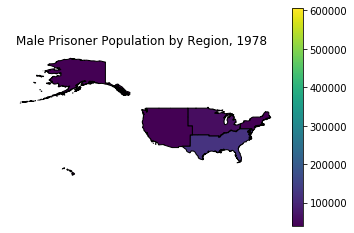

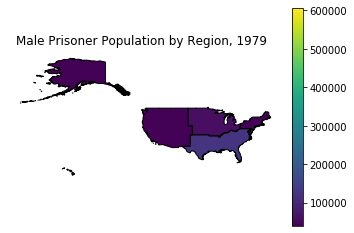

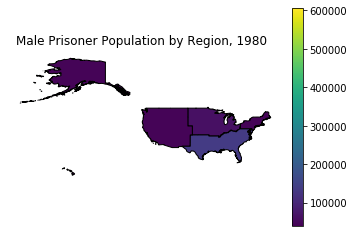

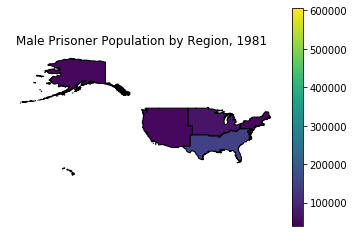

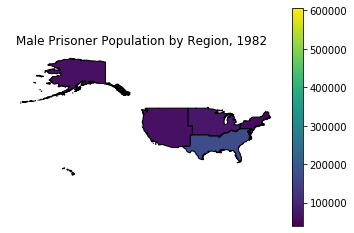

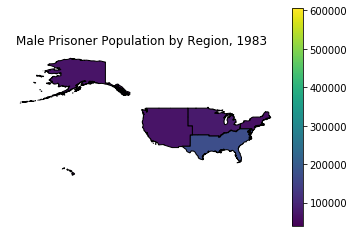

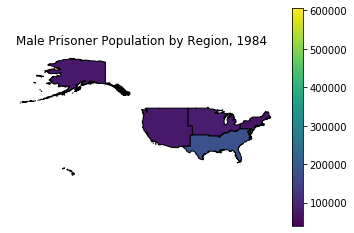

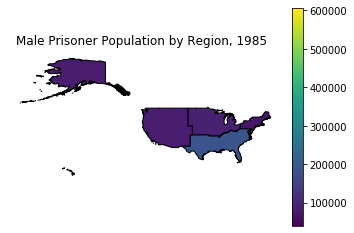

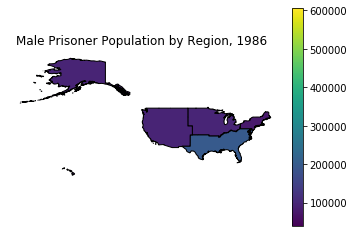

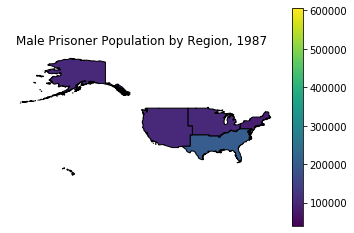

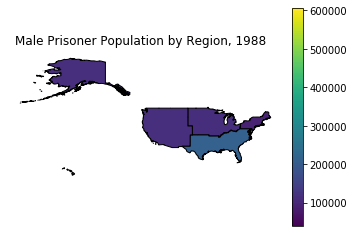

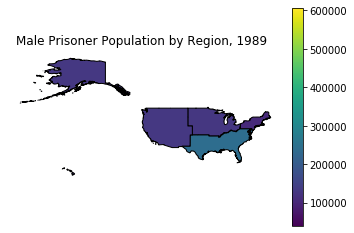

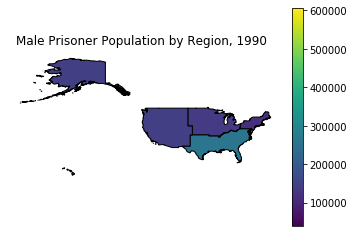

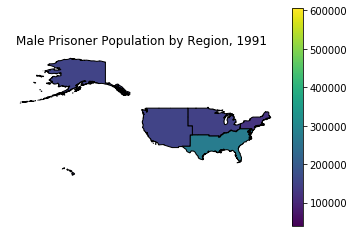

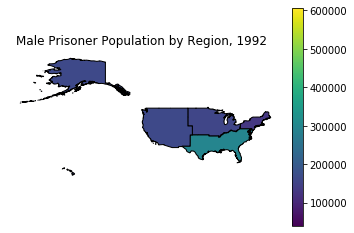

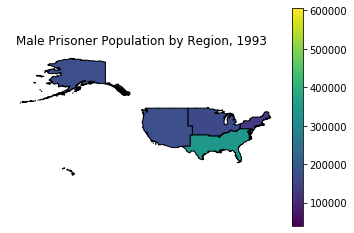

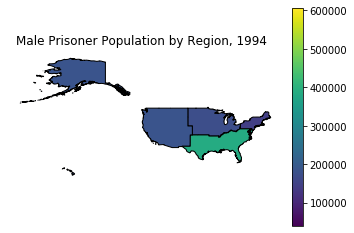

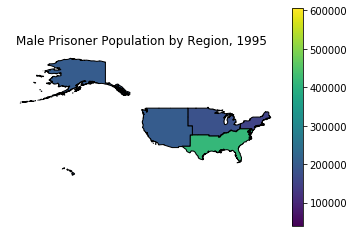

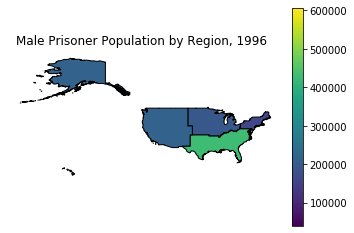

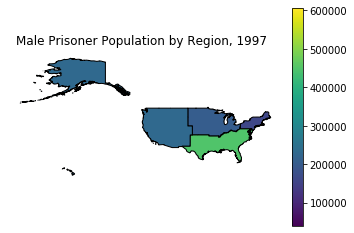

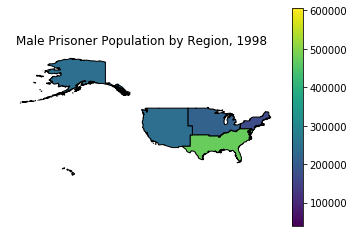

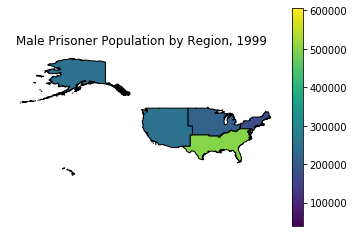

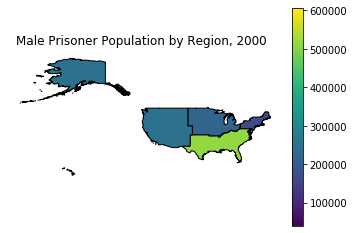

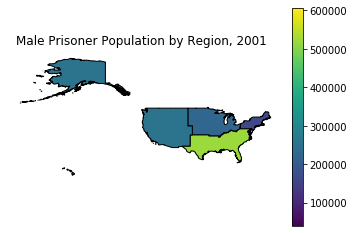

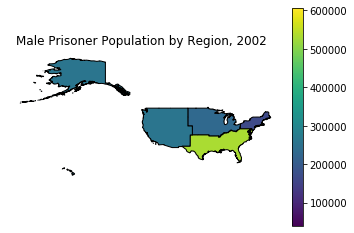

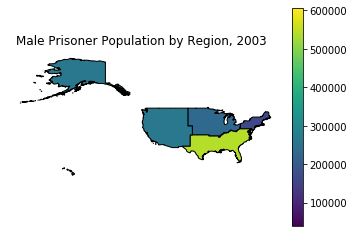

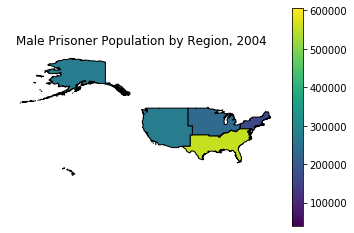

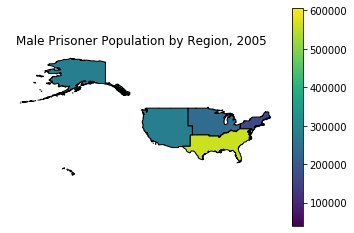

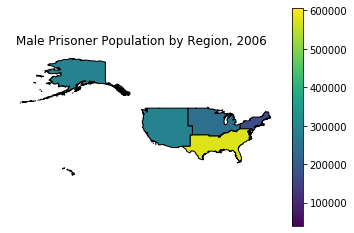

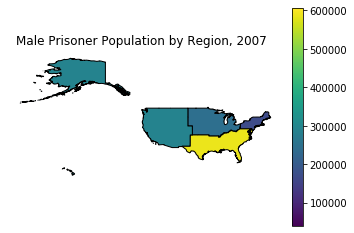

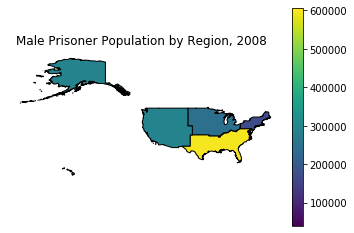

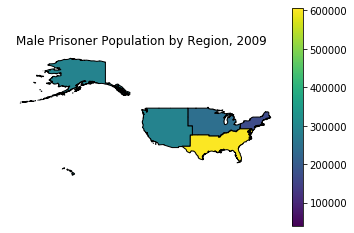

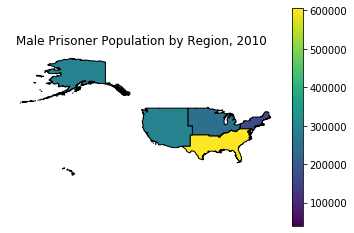

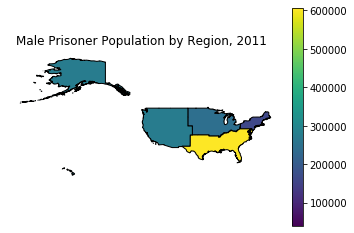

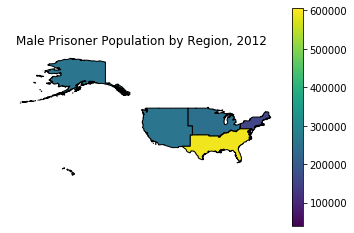

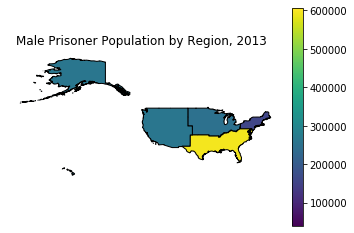

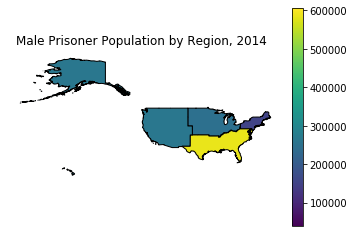

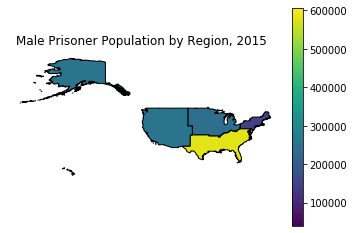

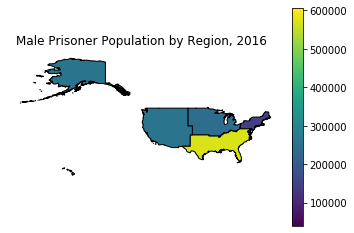

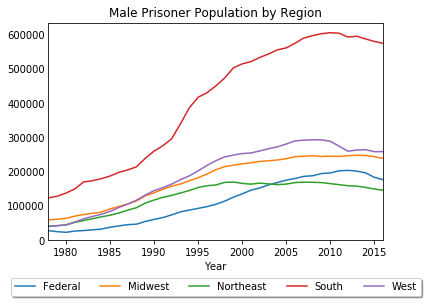

In [25]:
plotRegionalPopulation(malePrisonerPopulationRegionSum, usMap, "Male")

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



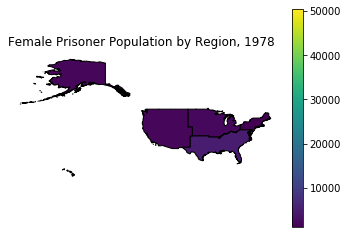

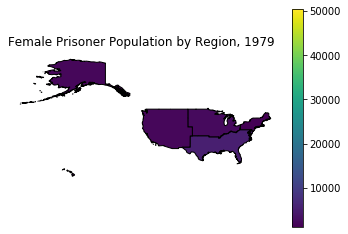

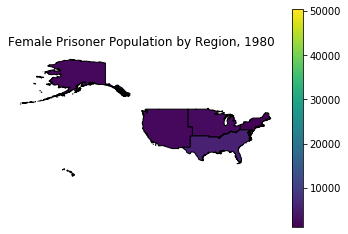

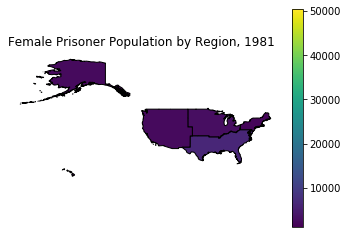

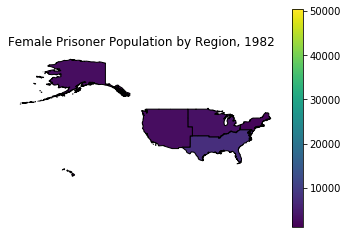

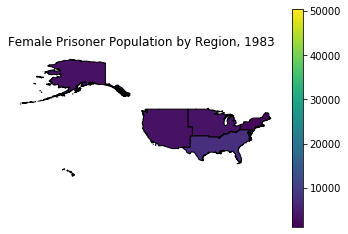

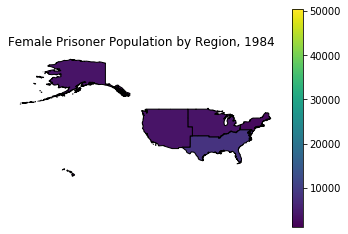

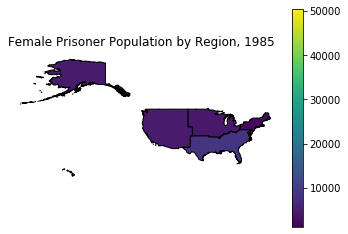

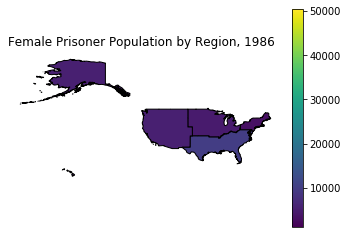

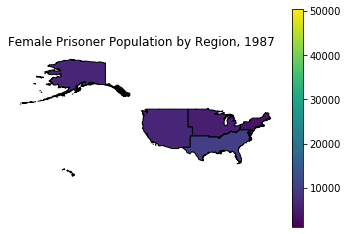

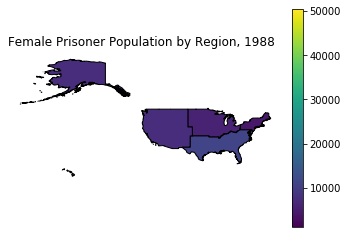

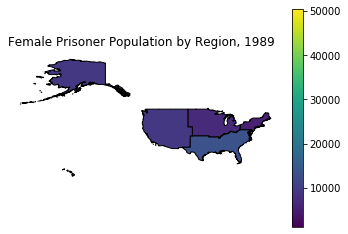

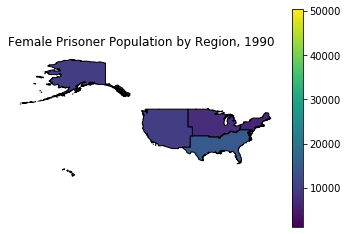

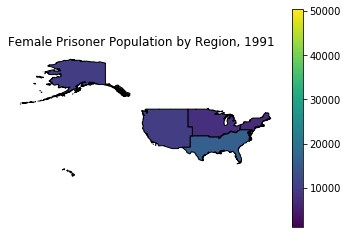

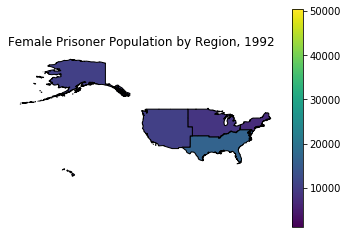

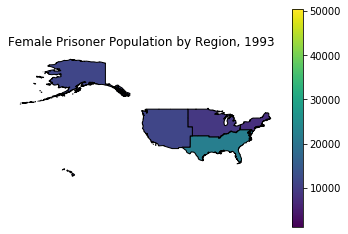

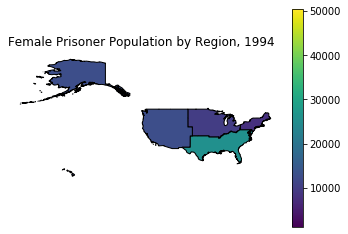

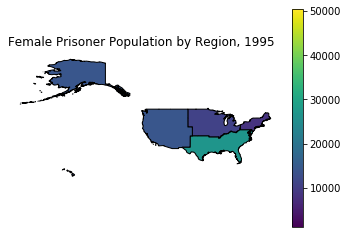

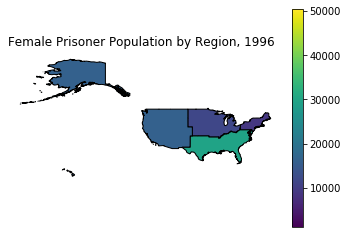

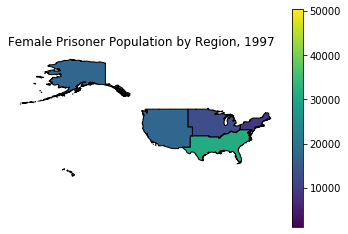

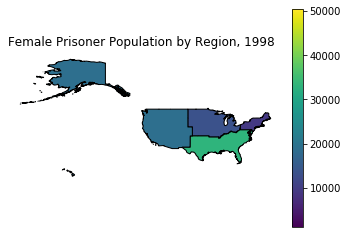

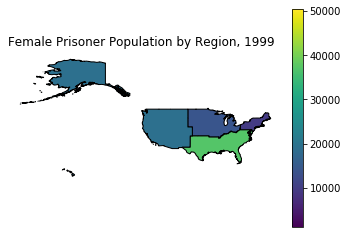

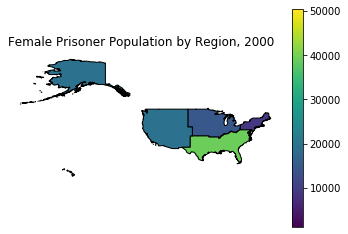

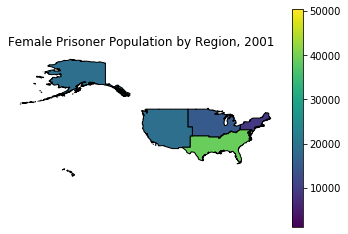

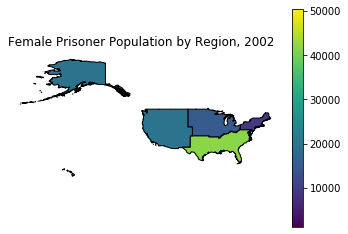

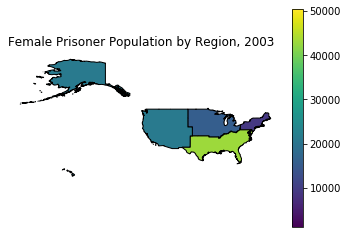

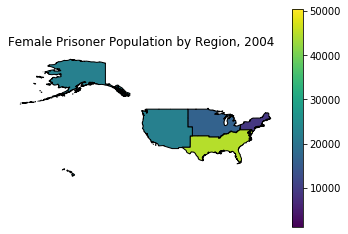

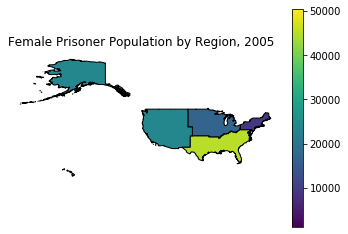

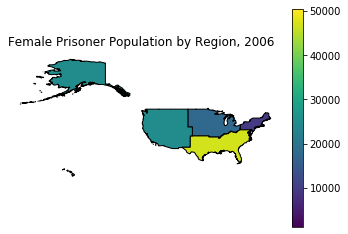

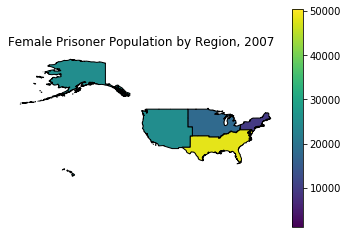

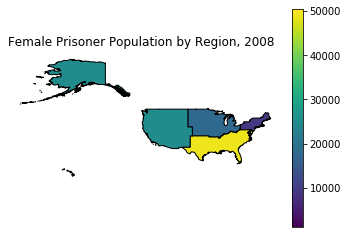

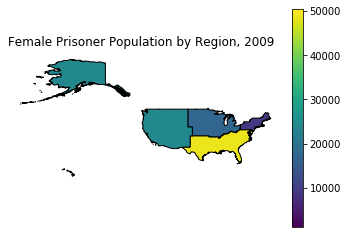

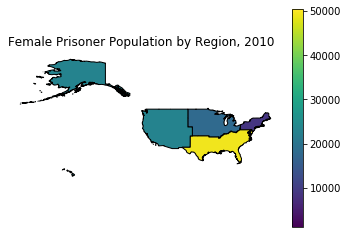

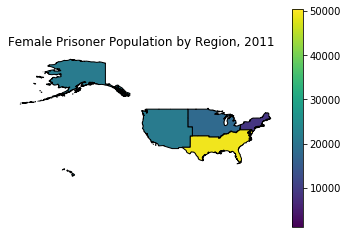

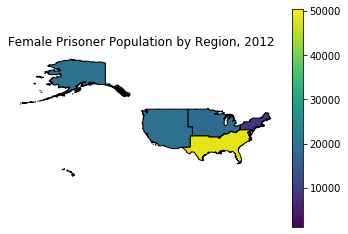

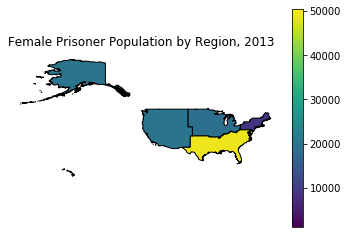

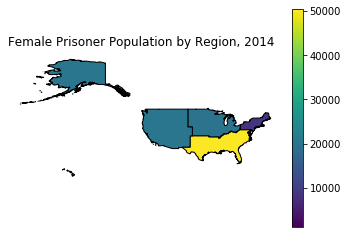

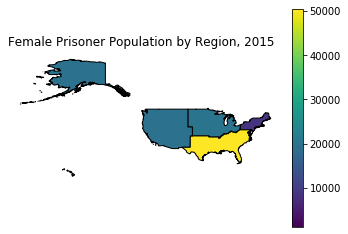

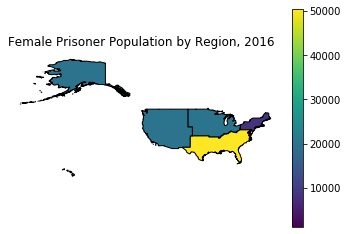

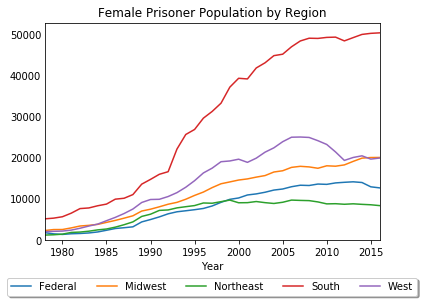

In [26]:
plotRegionalPopulation(femalePrisonerPopulationRegionSum, usMap, "Female")

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



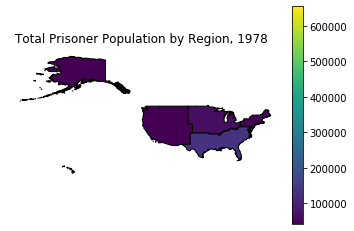

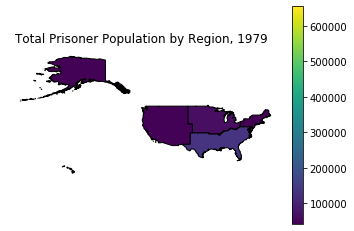

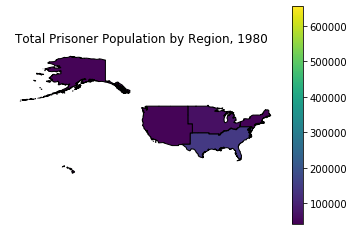

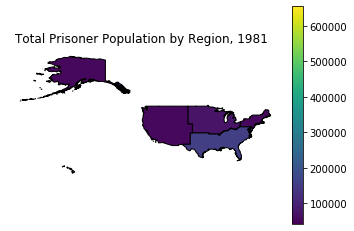

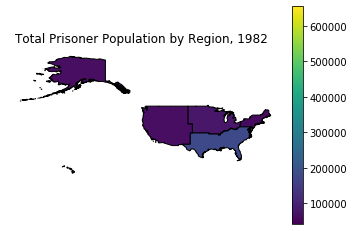

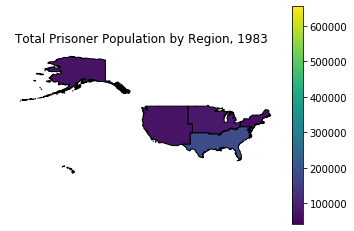

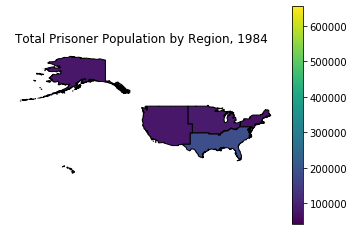

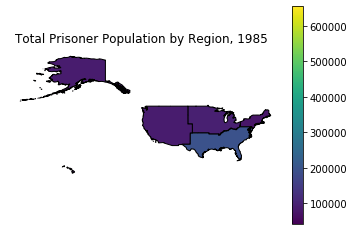

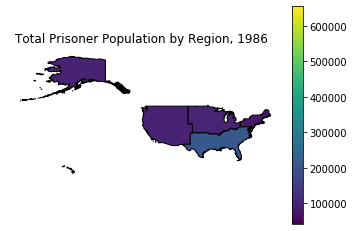

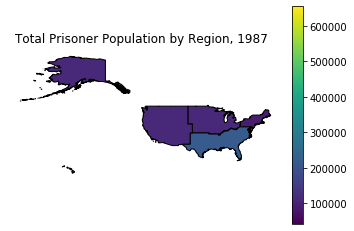

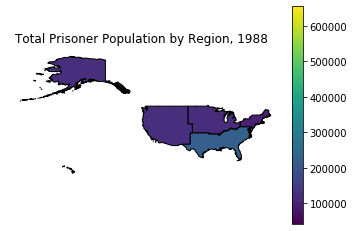

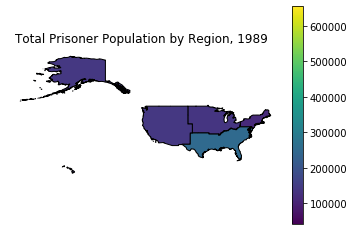

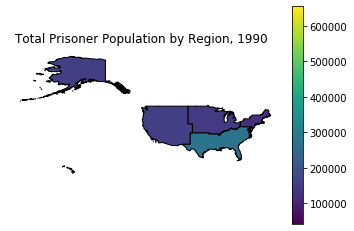

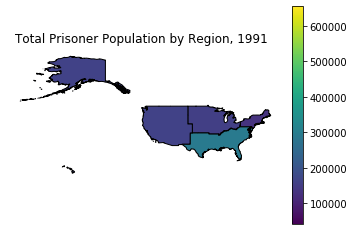

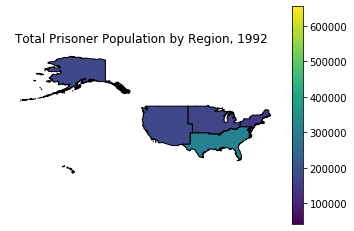

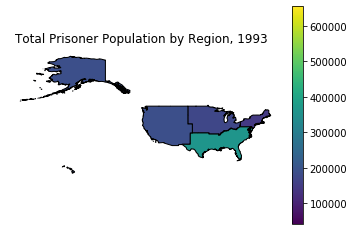

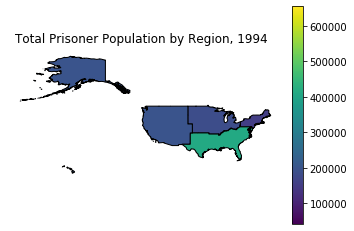

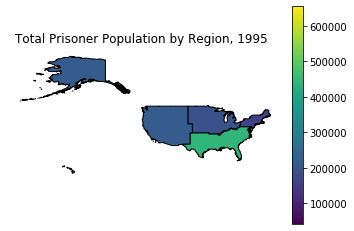

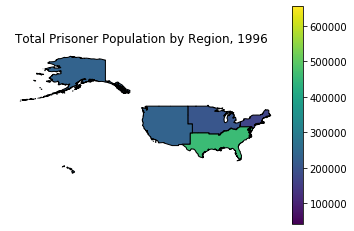

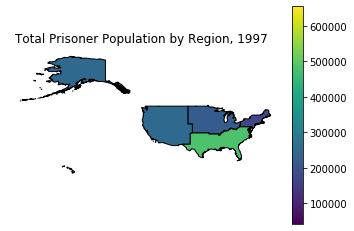

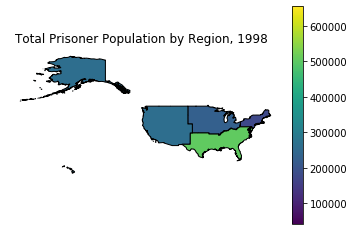

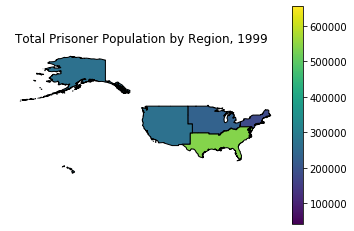

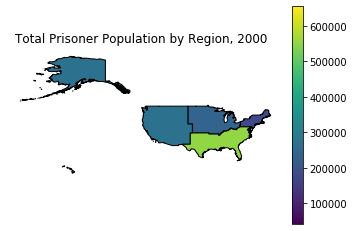

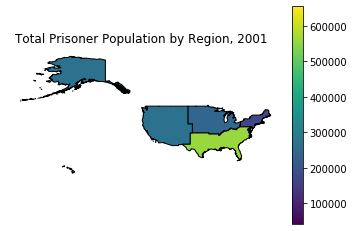

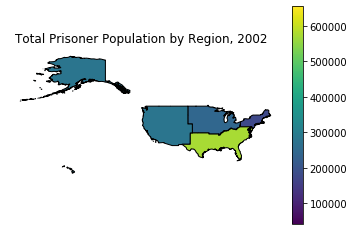

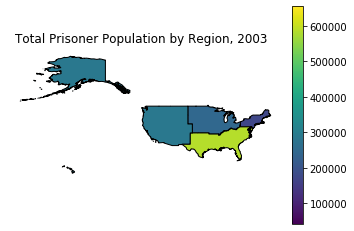

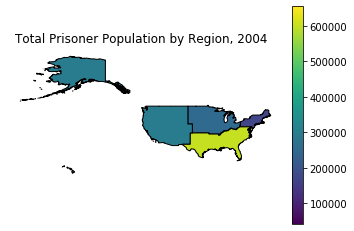

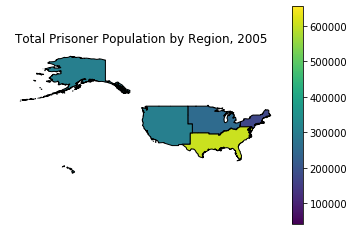

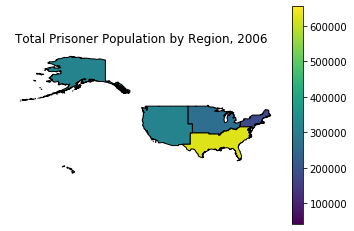

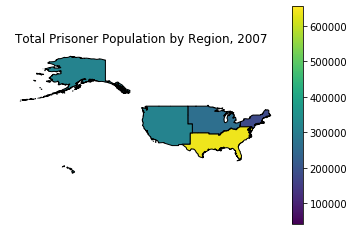

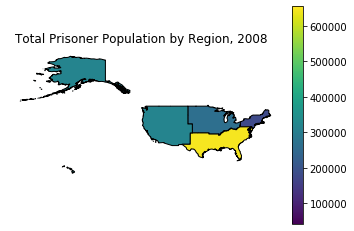

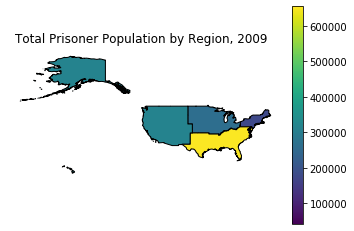

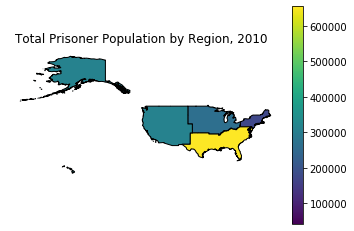

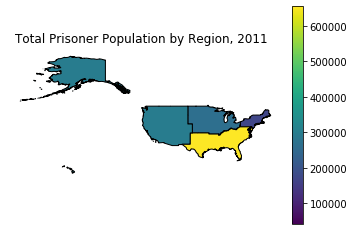

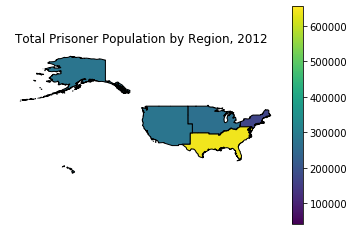

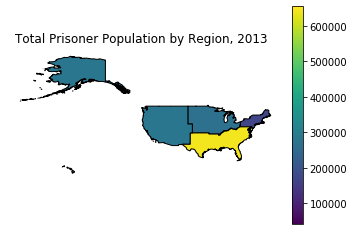

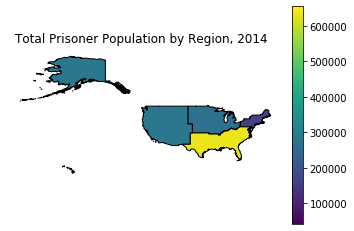

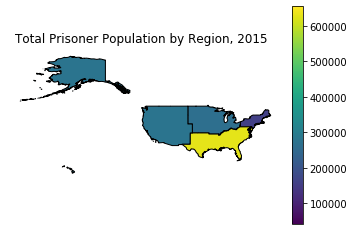

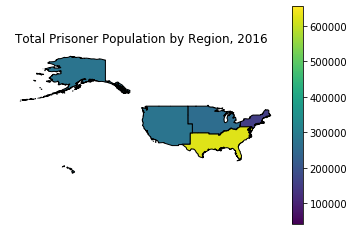

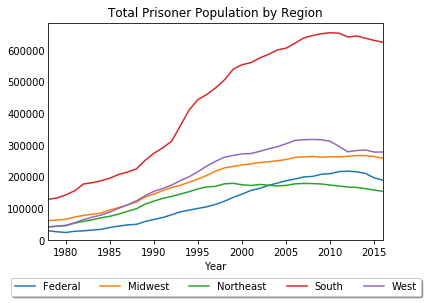

In [27]:
plotRegionalPopulation(totalPrisonerPopulationRegionSum, usMap, "Total")

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



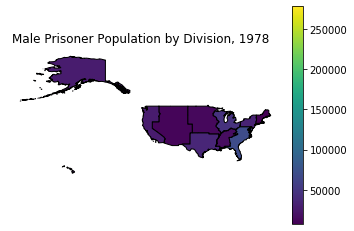

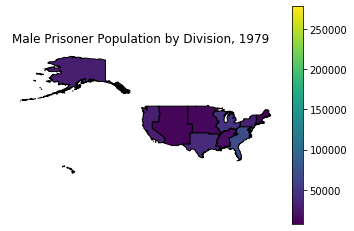

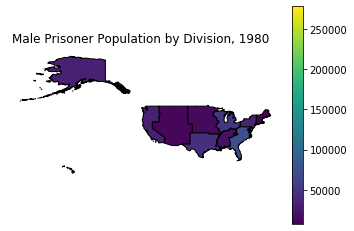

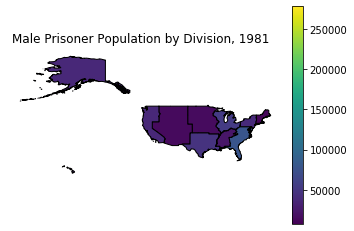

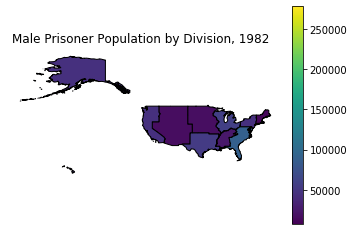

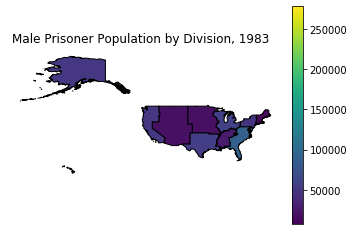

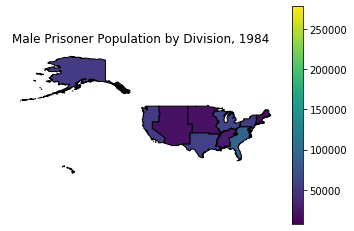

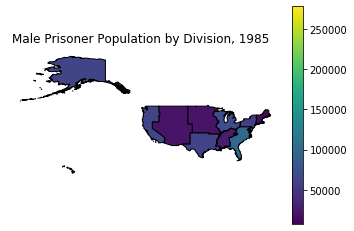

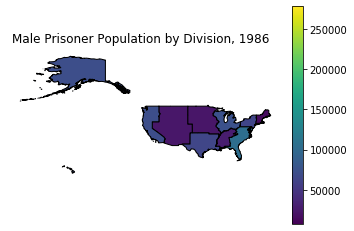

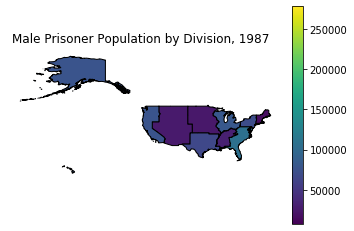

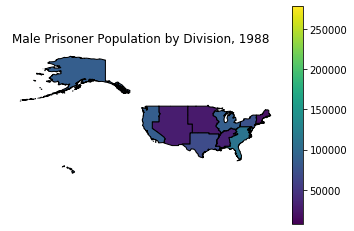

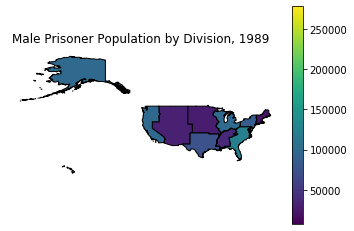

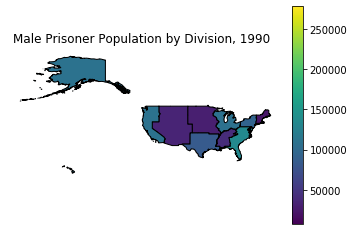

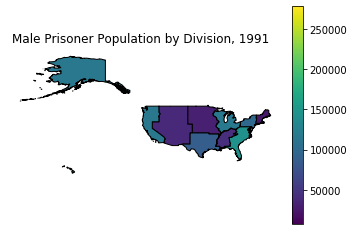

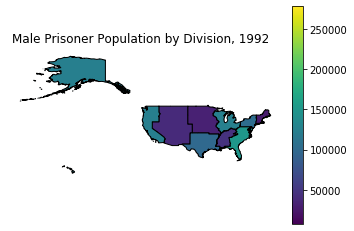

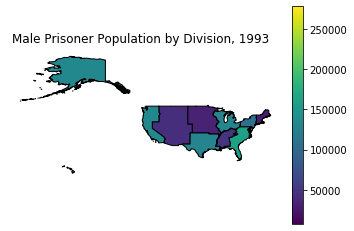

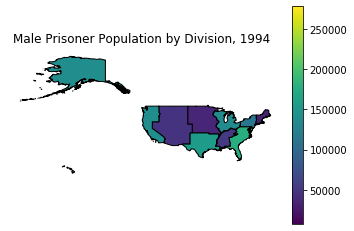

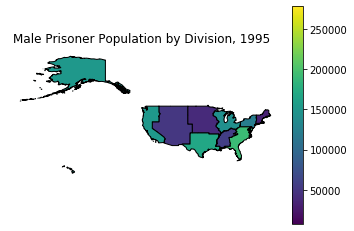

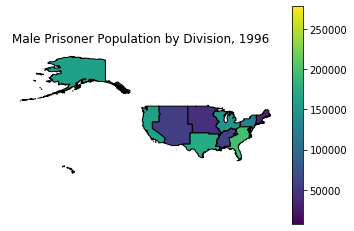

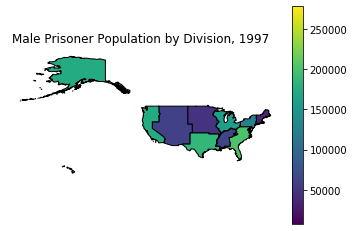

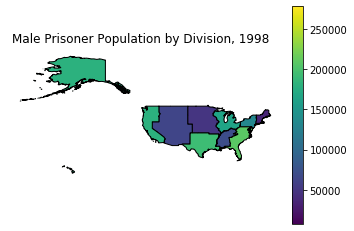

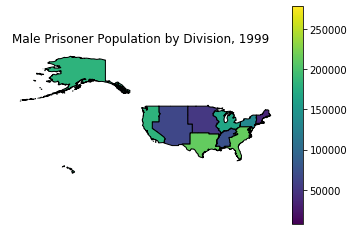

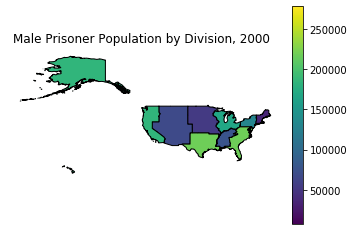

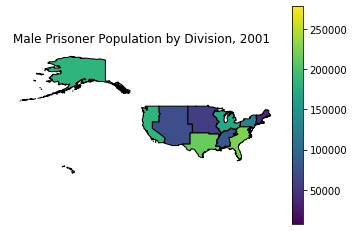

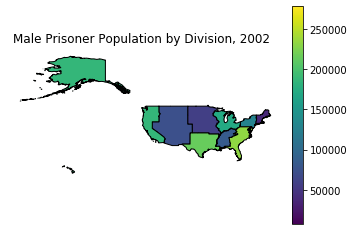

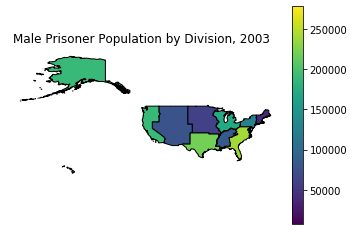

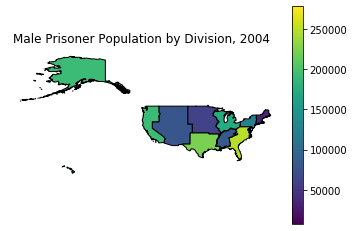

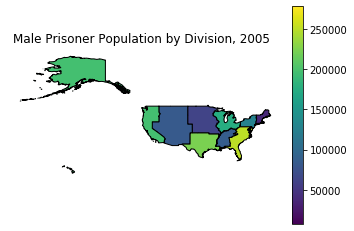

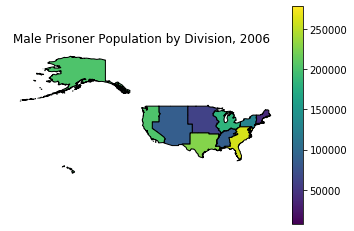

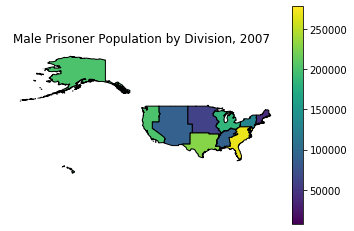

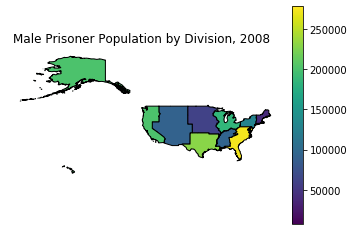

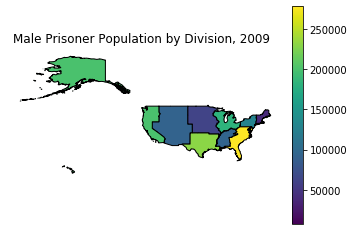

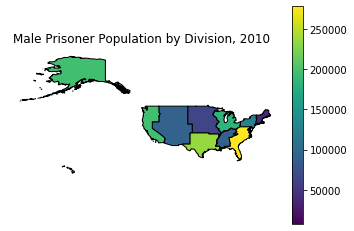

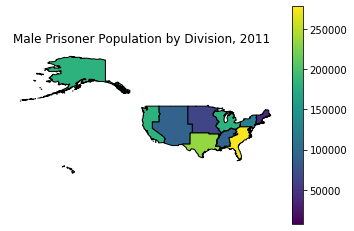

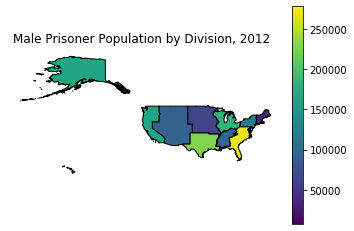

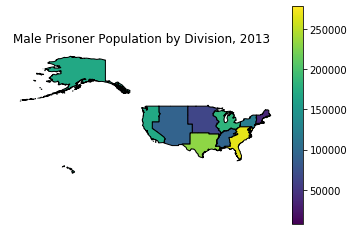

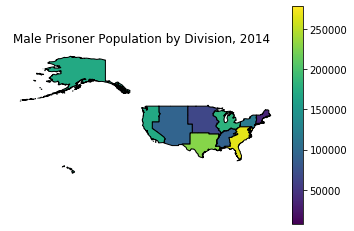

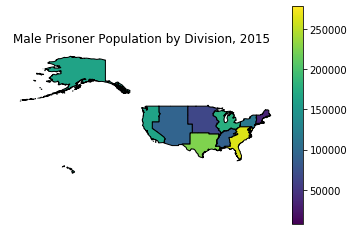

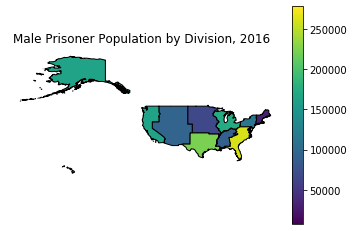

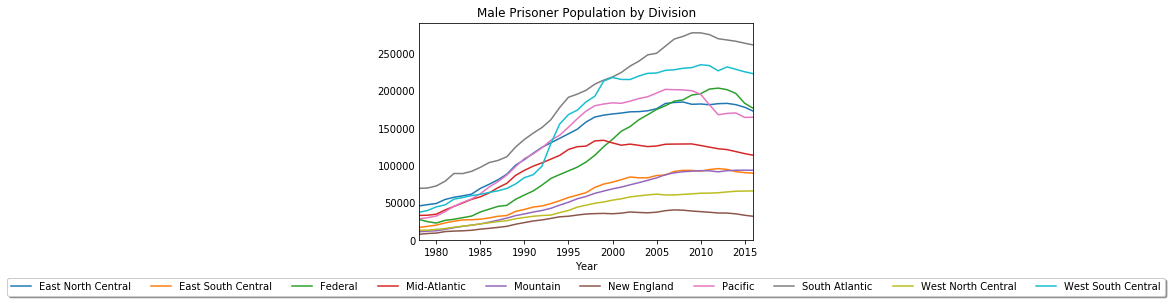

In [28]:
def dropRegionIndex(table):
    table = copy.deepcopy(table)
    
    table.index = table.index.droplevel(1)
    return table


plotRegionalPopulation(dropRegionIndex(malePrisonerPopulationDivisionSum), usMap, "Male")

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



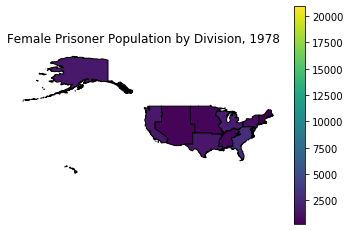

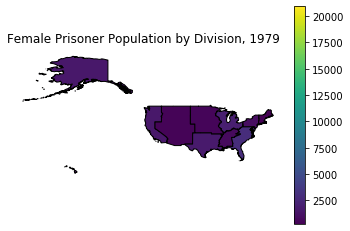

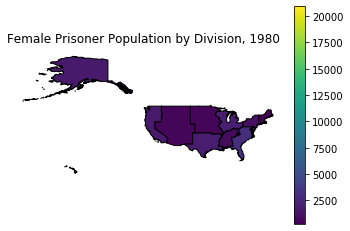

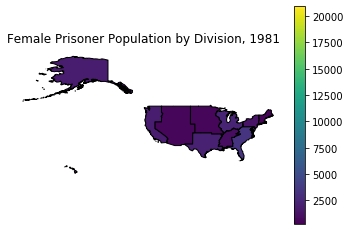

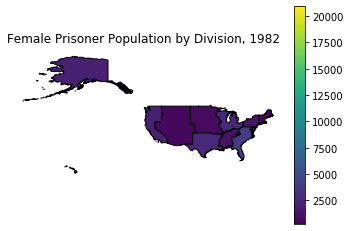

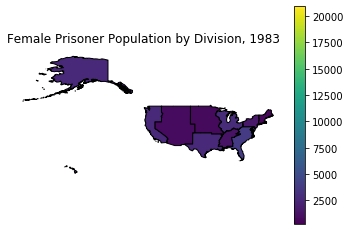

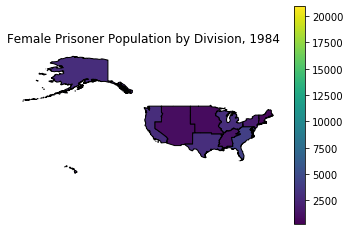

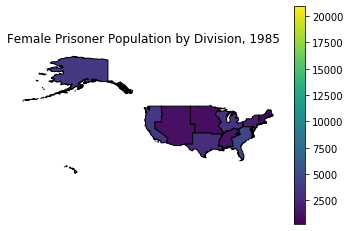

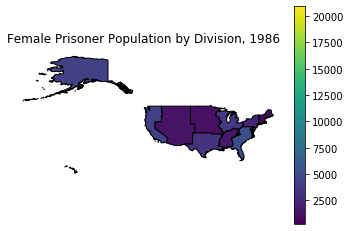

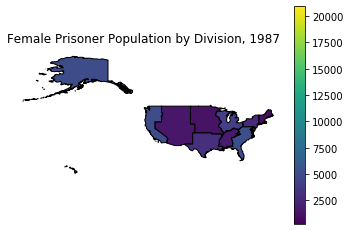

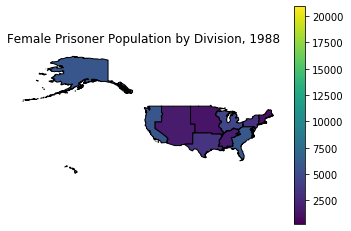

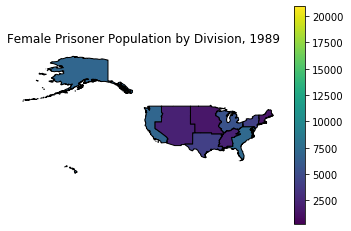

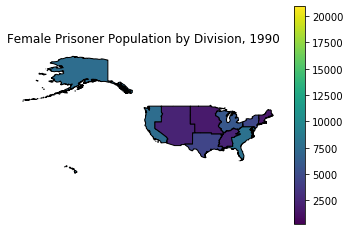

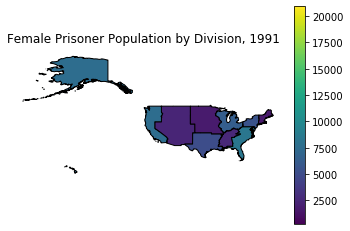

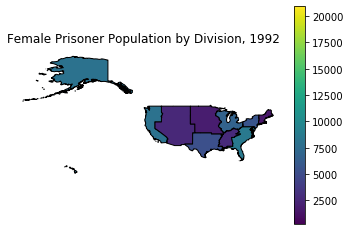

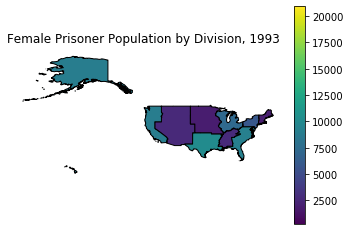

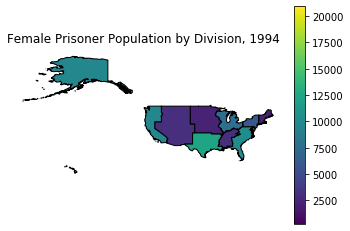

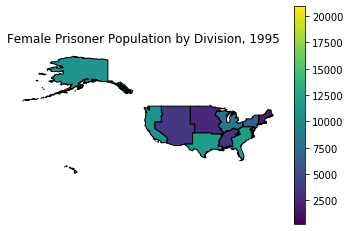

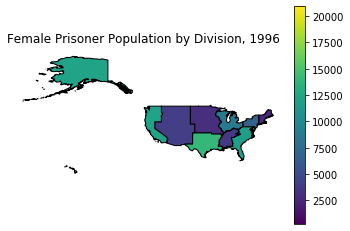

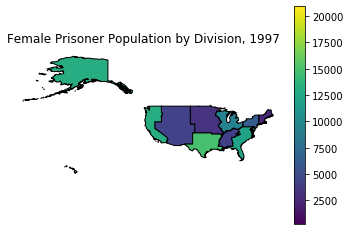

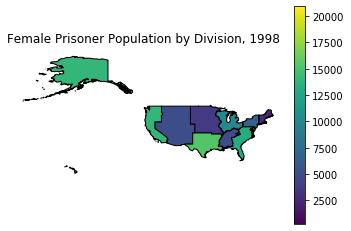

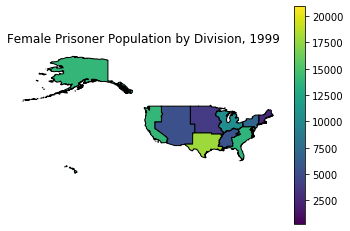

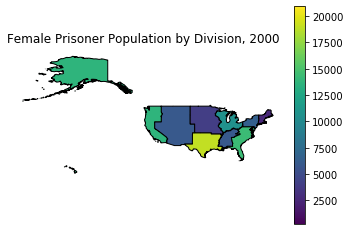

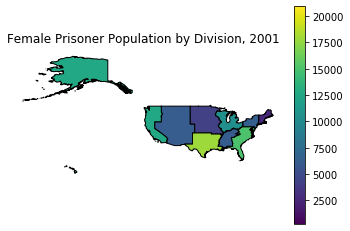

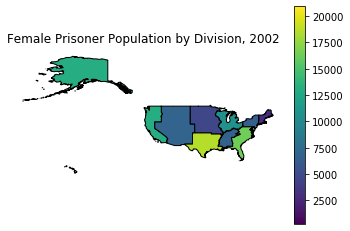

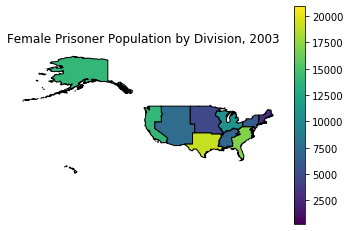

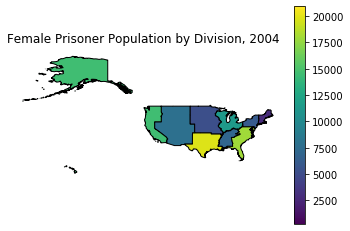

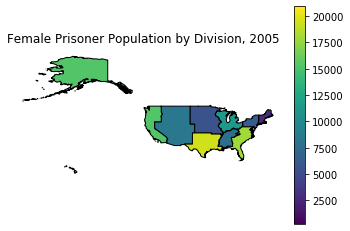

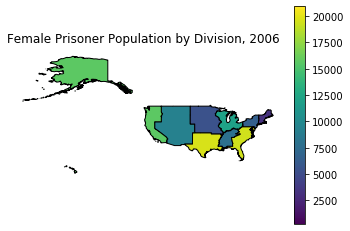

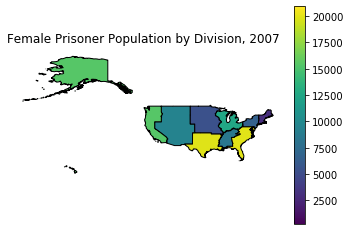

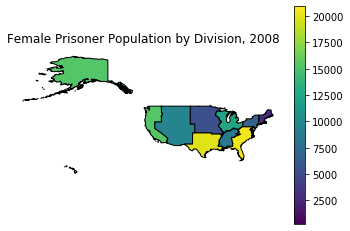

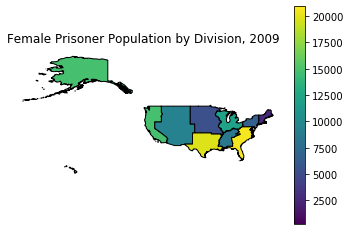

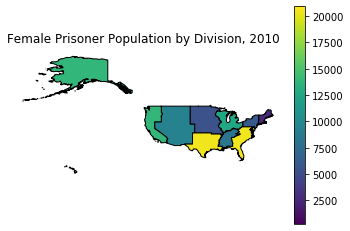

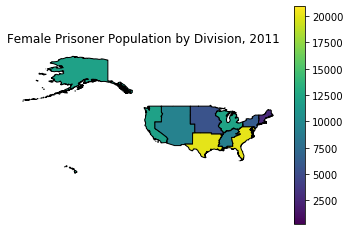

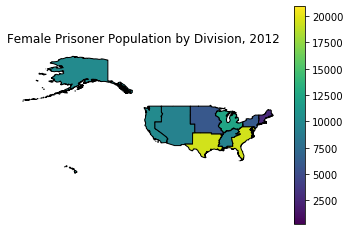

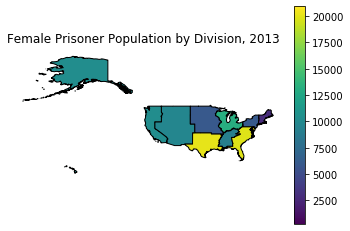

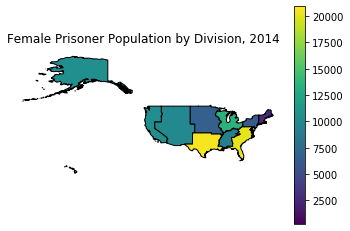

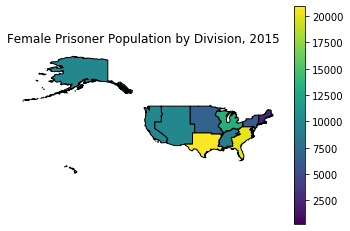

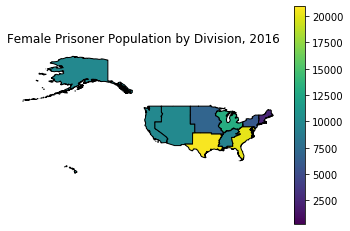

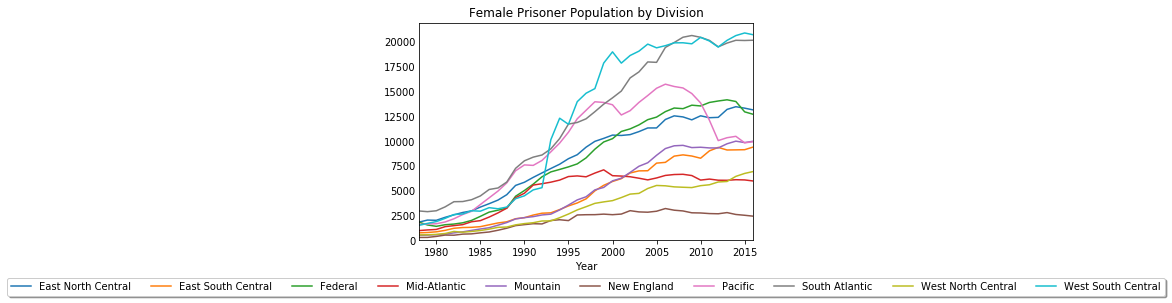

In [29]:
plotRegionalPopulation(dropRegionIndex(femalePrisonerPopulationDivisionSum), usMap, "Female")

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



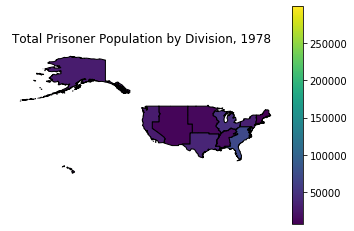

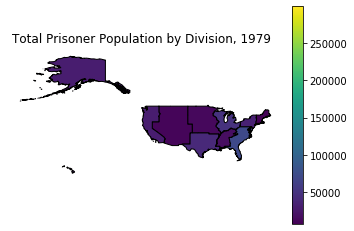

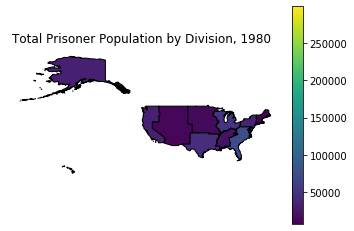

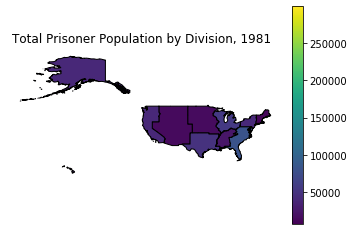

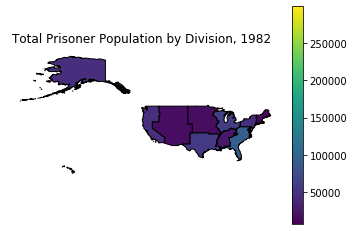

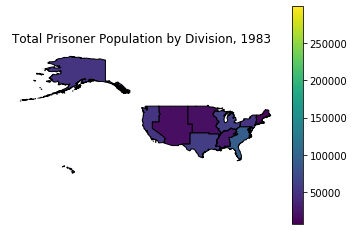

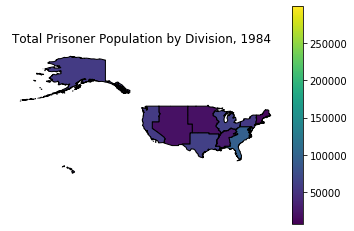

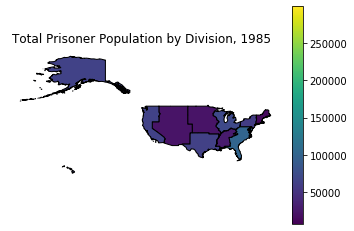

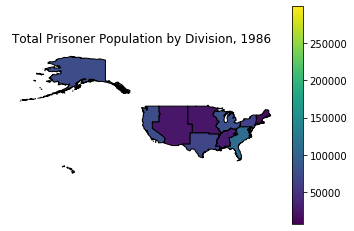

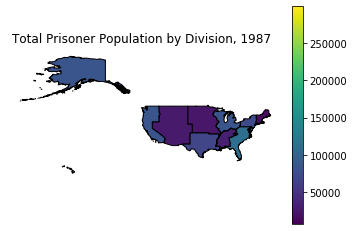

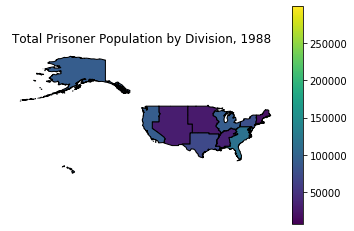

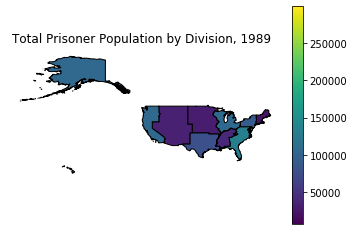

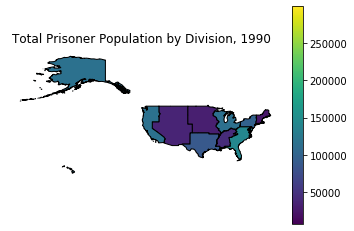

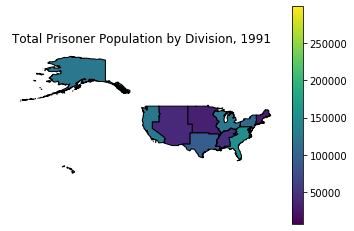

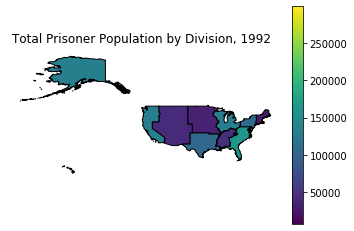

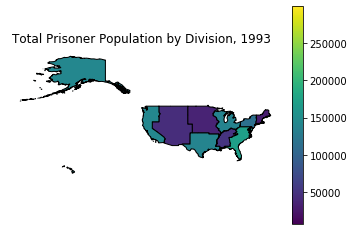

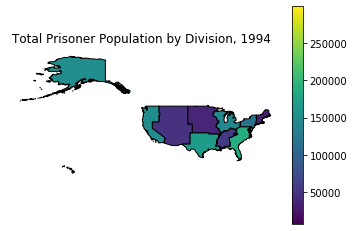

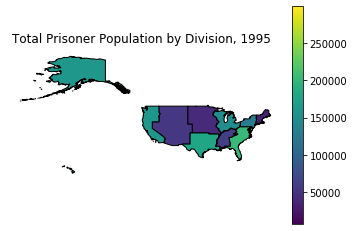

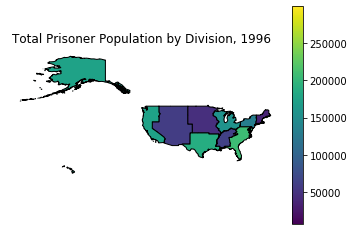

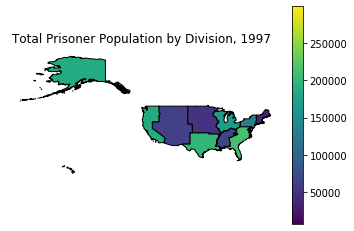

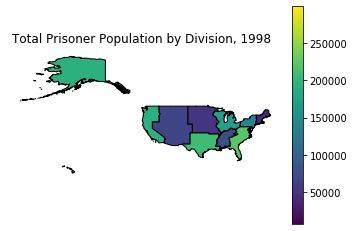

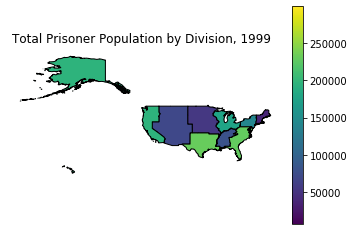

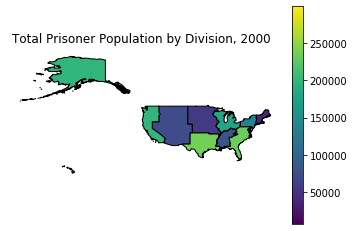

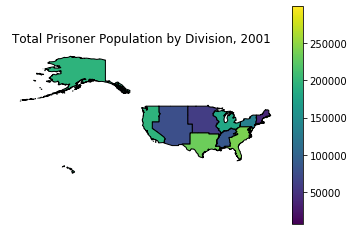

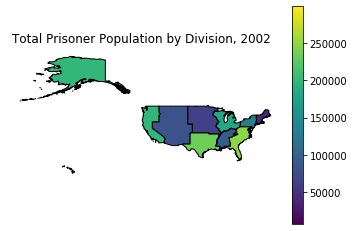

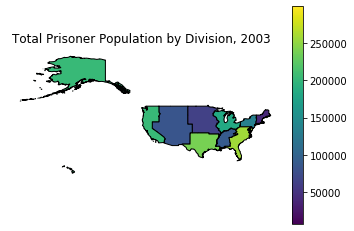

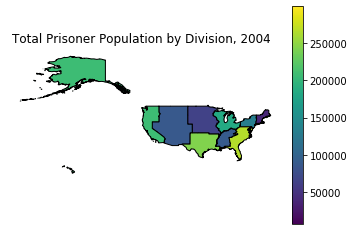

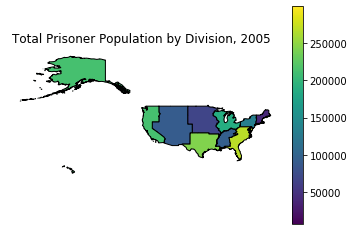

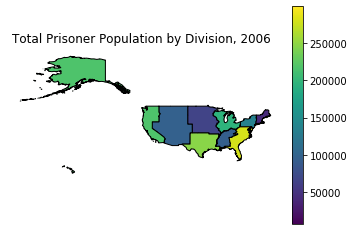

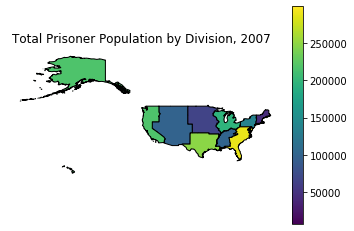

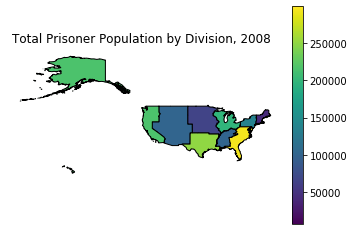

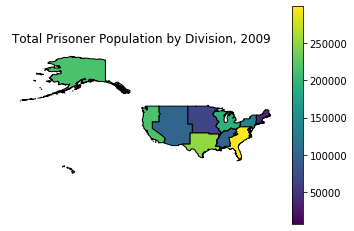

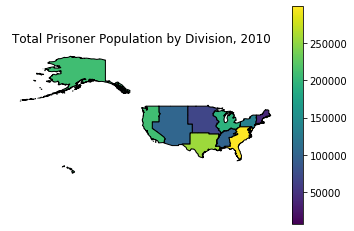

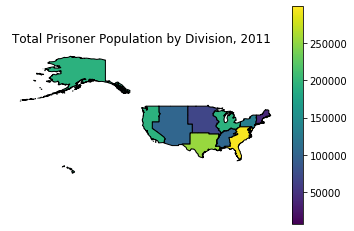

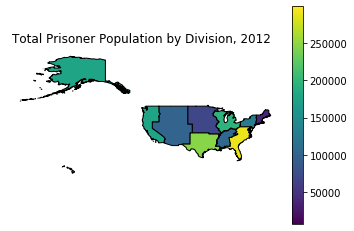

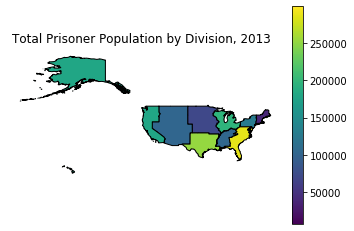

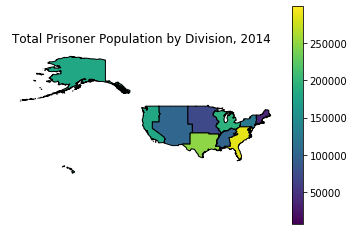

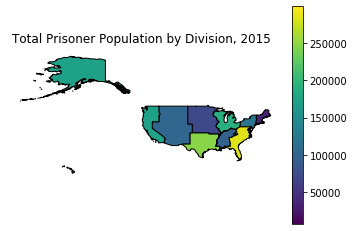

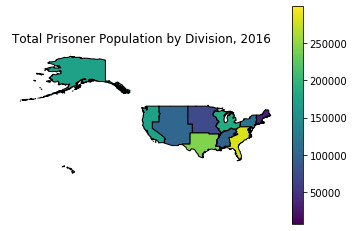

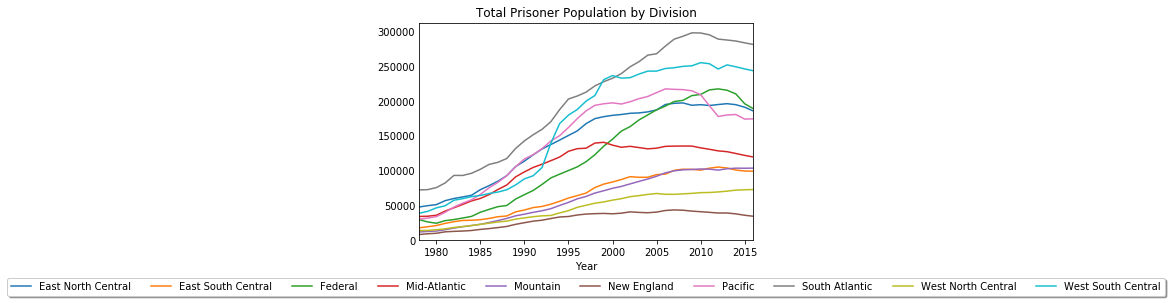

In [30]:
plotRegionalPopulation(dropRegionIndex(totalPrisonerPopulationDivisionSum), usMap, "Total")